## Surfaces for plots

* Surfaces to .db files for plotting

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append('../scripts')
from functions import *

In [4]:
surface_stochiometry = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
surface = initialize_surface(dim_x, dim_y, metals, surface_stochiometry)

Make HEA surface for plotting

In [5]:
from ase.build import fcc111
from ase.db import connect

atoms = fcc111("Cu", size = (20, 20, 3), a=3.8)
symbols = np.random.choice(metals, size = 20*20*3)
atoms.set_chemical_symbols(symbols)

db_file_path = "../Writing/Thesis_Figures/Dboys/"
filename = "HEA.db"
with connect(db_file_path+filename) as db:
    db.write(atoms)

In [6]:
symbols

array(['Pt', 'Pd', 'Ag', ..., 'Pd', 'Cu', 'Pd'], dtype='<U2')

Make SWR surface for plotting

In [7]:
dim_x, dim_y, dim_z = 20, 20, 3
SWR_surface = initialize_swim_surface(["Pt"], ["Au"], dim_x, dim_y)
symbols = SWR_surface["atoms"].flatten()

In [9]:
from ase.build import fcc111
from ase.db import connect

atoms = fcc111("Cu", size = (20, 20, 3), a=3.8)

SWR_surface = initialize_swim_surface(["Pt"], ["Au"], dim_x, dim_y)
symbols = SWR_surface["atoms"].flatten()
atoms.set_chemical_symbols(symbols)

db_file_path = "../Writing/Thesis_Figures/Dboys/"
filename = "SWR.db"
with connect(db_file_path+filename) as db:
    db.write(atoms)

Doesn't look like a proper swim ring surface, find the place where I already did that - I didn't, I just made it for plotting

Making a forced optimal top layer and the same 1/3 underneath

In [48]:
def generate_top_layer(dim_x, dim_y):
    pattern = ["Pt", "Au", "Au"]
    top_layer = []

    for i in range(dim_y):
        row = []

        # Calculate the starting index for this row
        start_index = (i * 2) % len(pattern)

        # Create the row with the repeating pattern
        for j in range(dim_x):
            row.append(pattern[(start_index + j) % len(pattern)])

        top_layer.append(row)

    return top_layer

In [49]:
# This works for making the .db file for the plot!

from ase.build import fcc111
from ase.db import connect

# Create the atoms object
atoms = fcc111("Cu", size = (20, 20, 3), a=3.8)

# Make the bottom two layers with the 1/3 frac
third_surface = create_surface(dim_x, dim_y, ["Pt", "Au"], [0.33, 0.67])
third_surface = third_surface.reshape(3, 20, 20)

# Generate the optimal swim ring top layer
top_layer_SWR = generate_top_layer(dim_x, dim_y)

# Switch out the top layer with the swim ring layer
third_surface[2,:,:] = top_layer_SWR

# Flatten the whole surface to get the symbols
symbols = third_surface.flatten()
symbols = symbols.reshape(3, 20, 20)
symbols = symbols.flatten()

# Set the symbols om the atoms object
atoms.set_chemical_symbols(symbols)

# Save the atoms object
db_file_path = "../Writing/Thesis_Figures/Dboys/"
filename = "SWR2.db"
with connect(db_file_path+filename) as db:
    db.write(atoms)

Soo my learnings are:

Ase thinks the shape is 3, 20, 20 instead of 20, 20, 3.
The code above makes swim rings that look good in ase

When I want to make swim rings that work when making feature vectors and predict energies I have to make the swim ring top layer in another way which looks right when i slice like this: 
surface["atoms"][:,:,0]

I'm not sure what I should do to optimize that hard set structure. Maybe input all five metals and stoichiometries as normal, but put Pd and Pt in the middle and Cu, Au, Ag in swim rings.

Anyways, now I have for my plot and then I'll keep on looking at the code that makes surfaces

## Now I'll use the *COOH model on an even HEA surface

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append('../scripts')
from functions import *

#### Create 200 by 200 HEA surface

In [3]:
# Initialize a surface from a given stochiometry
dim_x, dim_y, split = 200, 200, [0.2 , 0.2 , 0.2 , 0.2 , 0.2 ]

HEA_surface = initialize_surface(dim_x, dim_y, metals, split)

# Predict energies on all sites for both adsorbates + mixed_sites
HEA_surface = precompute_binding_energies_SPEED(HEA_surface, dim_x, dim_y, models)

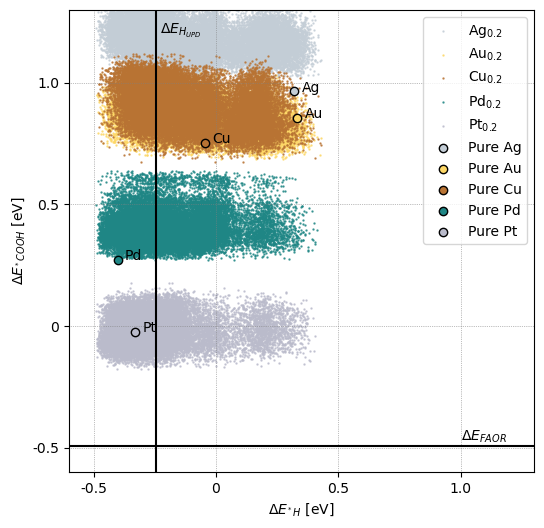

In [32]:
experiment_name = "Binding_Energy_Predictions/H_COOH_HEA_EVEN"
reward_type = "None"
title_text = "Predicted energies for $^*COOH$ and $^*H$ for whole surface"
title_text = ""

deltaEdeltaE_plot(experiment_name, HEA_surface, title_text, pure_metal_info, reward_type, True)

In [46]:
number_matrix = HEA_surface["COOH_E"]
label_matrix  = HEA_surface["atoms"][:,:,0]

# Find unique labels in the label matrix
unique_labels = np.unique(label_matrix)

# Initialize a dictionary to store separated numbers by label
separated_numbers = {label: [] for label in unique_labels}

# Iterate through labels and separate numbers
for label in unique_labels:
    mask = (label_matrix == label)  # Create a boolean mask for the current label
    numbers_for_label = number_matrix[mask]  # Use the mask to filter numbers
    separated_numbers[label] = numbers_for_label

# separated_numbers will now contain arrays of numbers for each label

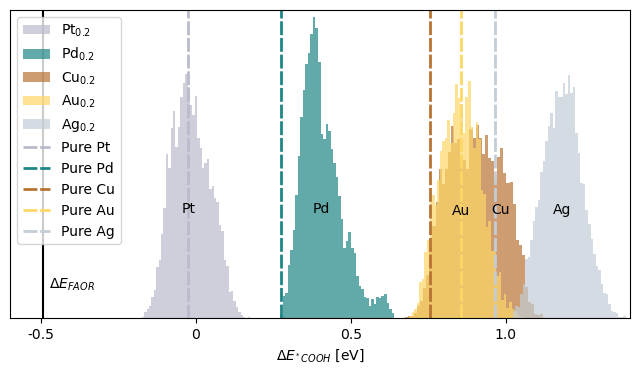

In [47]:
fig, ax = plt.subplots(figsize = (8, 4))

stochiometry = HEA_surface["stochiometry"]
for metal, numbers in reversed(separated_numbers.items()):
    ax.hist(numbers, label = f"{metal}$_{{{stochiometry[metal]:.1f}}}$", bins = 45, color = metal_colors[metal], alpha = 0.7, histtype='stepfilled')
    if metal == "Cu":
        ax.text(x = np.mean(numbers)+0.05, y = len(numbers)/45, s = metal)
    else:
        ax.text(x = np.mean(numbers)-0.03, y = len(numbers)/45, s = metal)

# Set the major ticks and tick labels
ax.set_xticks([-0.5, 0, 0.5, 1.0])
ax.set_xticklabels([-0.5, 0, 0.5, 1.0])
ax.set_yticks([])
ax.set_yticklabels([])

# Set the limits for the x axis
ax.set_xlim(-0.6, 1.4)
ax.set_ylim(0, 525)

ax.set_xlabel("$\Delta E_{^*COOH}$ [eV]")

ax.axvline(x = -corrections["COOH"], ymin = 0, ymax = 1, c = "black")
ax.text(x =  -corrections["COOH"]+0.02, y = 50, s = "$\Delta E_{FAOR}$")

# Add vertical lines for pure metal energies
for metal, metal_energy in zip(reversed(pure_metal_info["SE_slab_metals"]), reversed(pure_metal_info["DeltaE_COOH"])):
    plt.vlines(metal_energy, ymin=0, ymax=600, colors=metal_colors[metal], linestyle=(0, (5, 1)), lw=2, label="Pure "+metal)

plt.legend()
plt.savefig("../figures/Binding_Energy_Predictions/COOH_E_HEA_EVEN.png", dpi = 400, bbox_inches = "tight")

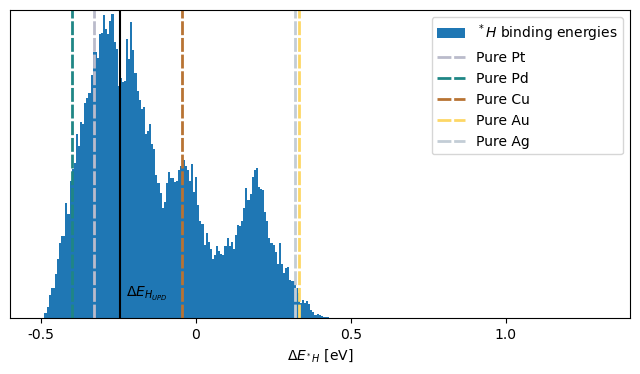

In [39]:
fig, ax = plt.subplots(figsize = (8, 4))

# Plot the data
plt.hist(HEA_surface["H_E"].flatten(), bins = 45*3+1, label = "$^*H$ binding energies")#, color = "#00aff0")

# Set the major ticks and tick labels
ax.set_xticks([-0.5, 0, 0.5, 1.0])
ax.set_xticklabels([-0.5, 0, 0.5, 1.0])
ax.set_yticks([])
ax.set_yticklabels([])

# Set the limits for the x axis
ax.set_xlim(-0.6, 1.4)
ax.set_ylim(0, 720)

ax.set_xlabel("$\Delta E_{^*H}$ [eV]")

ax.axvline(x = -corrections["H"], ymin = 0, ymax = 1, c = "black")
ax.text(x =  -corrections["H"]+0.02, y = 50, s = "$\Delta E_{H_{UPD}}$")

# Add vertical lines for pure metal energies
for metal, metal_energy in zip(reversed(pure_metal_info["SE_slab_metals"]), reversed(pure_metal_info["DeltaE_H"])):
    plt.vlines(metal_energy, ymin=0, ymax=755, colors=metal_colors[metal], linestyle=(0, (5, 1)), lw=2, label="Pure "+metal)

ax.legend()

plt.savefig("../figures/Binding_Energy_Predictions/H_E_HEA_EVEN.png", dpi = 400, bbox_inches = "tight")

In [ ]:
# Could I make a different colour for each metal present?
# One histogram for all metals seperately present in the 3 closest?
# All energies will be present 3 times

# Could I use the roll thing and then look at same index?

# If I do it once, I will get one third of them

# It's just the same procedure as before, just three times where
# I roll the top atoms real quick

# Oh I should put the pure metal energies in there also.
# I could do the same for COOH


In [48]:
# Assuming HEA_surface["atoms"] is your 2D numpy array
label_matrix0 = HEA_surface["atoms"][:,:,0]
number_matrix = HEA_surface["H_E"]

# Roll the contents down by one position along axis 0
label_matrix1 = np.roll(label_matrix0, shift=1, axis=0) # Works

# Roll the contents to the left by one position along axis 1
label_matrix2 = np.roll(label_matrix0, shift=-1, axis=1) # Works

# Find unique labels in the label matrix
unique_labels = np.unique(label_matrix0)

# Initialize a dictionary to store separated numbers by label
separated_numbers = {label: [] for label in unique_labels}

for label_matrix in [label_matrix0, label_matrix1, label_matrix2]:

    # Iterate through labels and separate numbers
    for label in unique_labels:
        mask = (label_matrix == label)  # Create a boolean mask for the current label
        numbers_for_label = number_matrix[mask]  # Use the mask to filter numbers
        separated_numbers[label].extend(numbers_for_label) #Den her skal plusse oveni i stedet for at erstatte

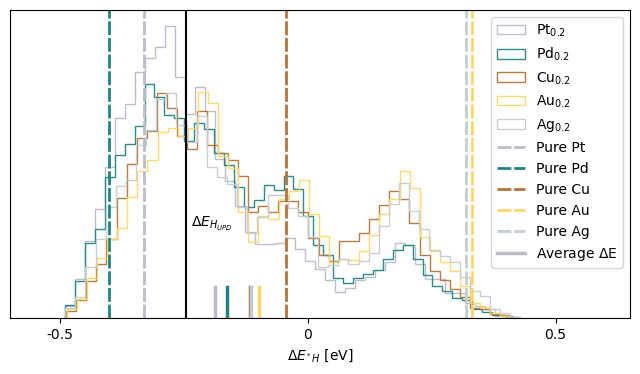

In [49]:
fig, ax = plt.subplots(figsize = (8, 4))

stochiometry = HEA_surface["stochiometry"]
# Plot the data
for metal, numbers in reversed(separated_numbers.items()):
    ax.hist(numbers, label = f"{metal}$_{{{stochiometry[metal]:.1f}}}$", bins = 45, color = metal_colors[metal], alpha = 0.95, histtype='step')

    #ax.text(x = np.mean(numbers), y = len(numbers)/45, s = metal)
    #ax.axvline(x = np.mean(numbers), ymin = 0, ymax = 0.1, linewidth = 2.5, color = metal_colors[metal])

# Set the major ticks and tick labels
ax.set_xticks([-0.5, 0, 0.5])
ax.set_xticklabels([-0.5, 0, 0.5])
ax.set_yticks([])
ax.set_yticklabels([])

# Set the limits for the x axis
ax.set_xlim(-0.6, 0.65)
ax.set_ylim(0, 1700)

ax.set_xlabel("$\Delta E_{^*H}$ [eV]")

ax.axvline(x = -corrections["H"], ymin = 0, ymax = 1, c = "black")
ax.text(x =  -corrections["H"]+0.01, y = 500, s = "$\Delta E_{H_{UPD}}$")

# Add vertical lines for pure metal energies
for metal, metal_energy in zip(reversed(pure_metal_info["SE_slab_metals"]), reversed(pure_metal_info["DeltaE_H"])):
    plt.vlines(metal_energy, ymin=0, ymax=1780, colors=metal_colors[metal], linestyle=(0, (5, 1)), lw=2, label="Pure "+ metal)
    #if metal == "Pt":
    #    plt.vlines(metal_energy, ymin=0, ymax=1480, colors=metal_colors[metal], linestyle='-', lw=2, label="Pure metal")
    #else:
    #    plt.vlines(metal_energy, ymin=0, ymax=1480, colors=metal_colors[metal], linestyle='-', lw=2)

for metal, numbers in reversed(separated_numbers.items()):
    if metal == "Pt":
        ax.axvline(x = np.mean(numbers), ymin = 0, ymax = 0.1, linestyle = "-", linewidth = 2.5, color = metal_colors[metal], label = "Average $\Delta$E")
    else:
        ax.axvline(x = np.mean(numbers), ymin = 0, ymax = 0.1, linestyle = "-", linewidth = 2.5, color = metal_colors[metal])

ax.legend()

plt.savefig("../figures/Binding_Energy_Predictions/H_E_HEA_EVEN_Details.png", dpi = 400, bbox_inches = "tight")


In [96]:
for metal, numbers in reversed(separated_numbers.items()):
    print("The average binding energy in a site where "+metal+" is present is: " + str(np.mean(numbers)))

The average binding energy in a site where Pt is present is: -0.18531996
The average binding energy in a site where Pd is present is: -0.16171914
The average binding energy in a site where Cu is present is: -0.118449405
The average binding energy in a site where Au is present is: -0.09527455
The average binding energy in a site where Ag is present is: -0.1055968


I want to load the pure metal energies automatic in functions.py

### Given energies compared to energies

In [ ]:
# Same surface, fish out the energies

In [51]:
HEA_surface.keys() #H_given_COOH_down etc. etc.


dict_keys(['atoms', 'stochiometry', 'ads_top', 'ads_hol', 'COOH_E', 'H_E', 'mixed_down', 'mixed_up_right', 'mixed_up_left', 'O_E', 'OH_E', 'H_V', 'O_V', 'COOH_V', 'OH_V', 'COOH_given_H_down', 'COOH_given_H_up_right', 'COOH_given_H_up_left', 'H_given_COOH_down', 'H_given_COOH_up_right', 'H_given_COOH_up_left'])